# Wavelet Packet And CNN

## Validate Data

In [13]:
import os
import numpy as np
from scipy.io import loadmat
from scipy import signal

MI_BEHAVIOR = ['Left hand', 'right hand', 'right foot']
CURR_DIR = os.getcwd()
PATH = os.path.join('./', 'EEG_MI_BCIIV', 'BCICIV_1', 'BCICIV_calib_ds1a.mat')

file = loadmat(PATH)

In [14]:
# cnt : continues EEG  data
# mrk : target of cue
MI_CHANNEL = ["C1", "C2", "Cz", "C3", "C4"]

originData = file['cnt']*0.1 # uv
movement = file['nfo'][0][0][1][0][0:2]
channel = [(i, item[0]) for i, item \
              in enumerate(file['nfo'][0][0][2][0]) 
                 if MI_CHANNEL in item]
mark = [*zip(file['mrk'][0][0][0][0], file['mrk'][0][0][1][0])]

print(f"data shape = {originData.shape}")
print(f"Motor Imagery channel : {MI_CHANNEL}")

data shape = (190594, 59)
Motor Imagery channel : ['C1', 'C2', 'Cz', 'C3', 'C4']


### Data Feature Extraction

In [15]:
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
color = ['r', 'b', 'g', 'navy', 'teal']
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

plt.rcParams.update({'text.color' : "teal",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

index = np.random.randint(0,200)
pos = mark[index][0]
channelNumber = [x for x,_ in channel]
channelLabel = [x for _,x in channel]
handleData = originData[:,channelNumber]

In [16]:
WINDOW = 400
SR = 100

#### Origin Data (Choose Random MI happened)

In [17]:
def subplotData(xs, ys, times, labels, fs):
    row = len(times)
    fig, ax = plt.subplots(nrows=row, ncols=2, figsize=(14, 4*row))
                           
    for epoch, _ in enumerate(times):
        yf = ys[:, epoch]
        xf = xs
        ax[epoch,0].plot(xf, yf, label=labels[epoch], color=color[epoch])
        ax[epoch,0].legend(loc='upper right')
        ax[epoch,0].set_title(f'Datasets of channel {labels[epoch]}', color='white')
        ax[epoch,0].set_xlim(0, len(xs))
        
        f, Pxx_spec = signal.periodogram(yf, fs, 'flattop', scaling='density')
        ax[epoch, 1].semilogy(f, Pxx_spec)
        ax[epoch, 1].set_title(f'PSD of channel {labels[epoch]}', color='white')
        ax[epoch, 1].set_xlabel(f'Hz')
        ax[epoch, 1].set_ylabel(f'PSD [V**2/Hz]')
    plt.tight_layout()
    plt.show()

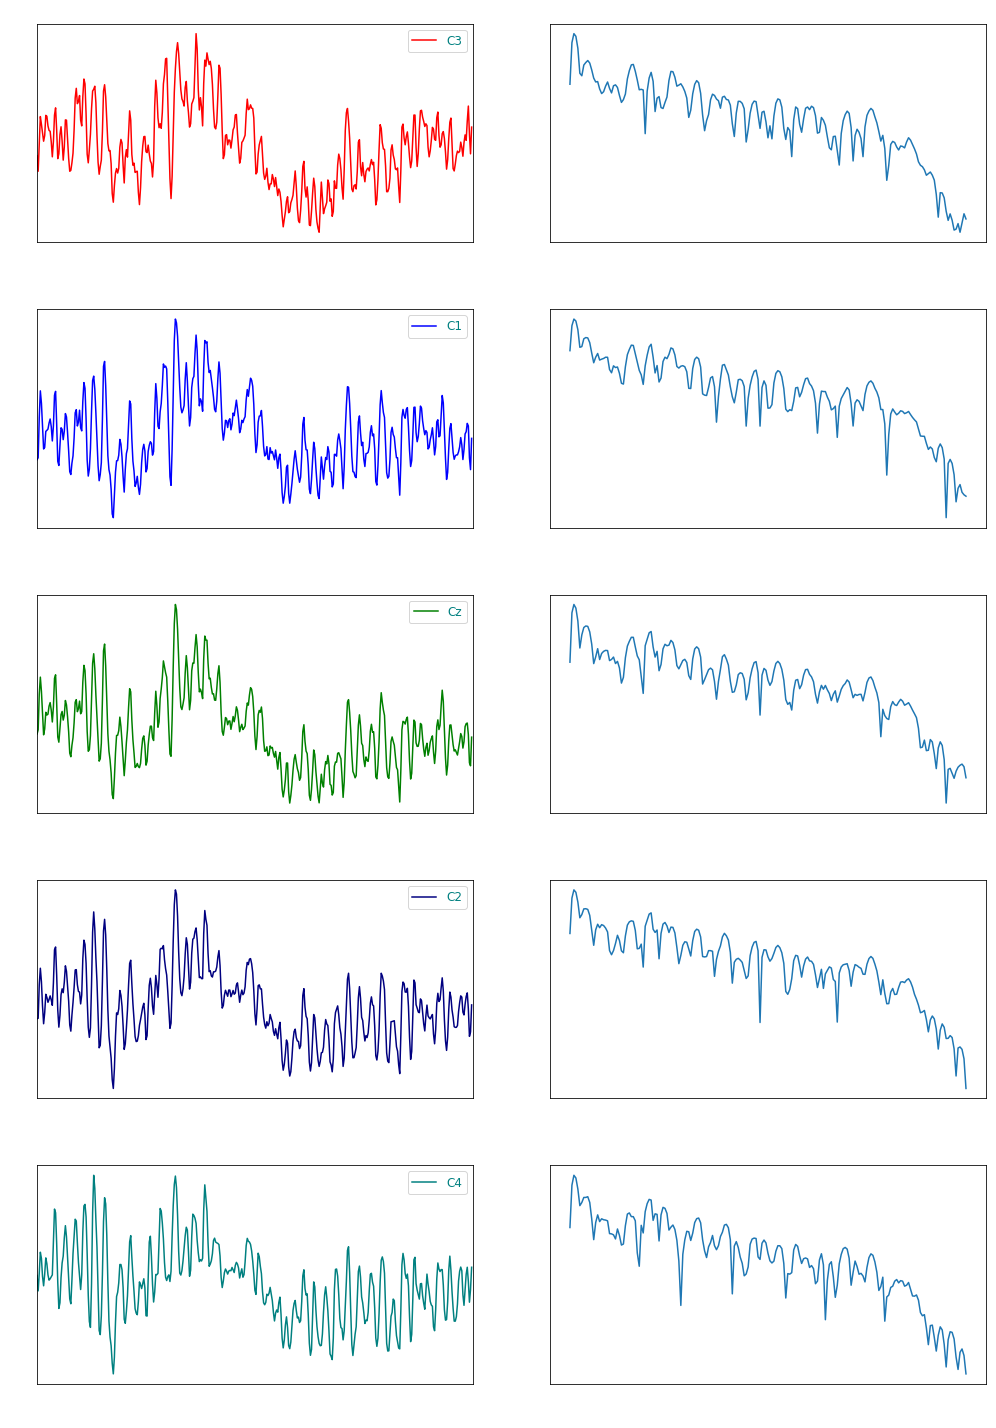

In [18]:
xs = range(WINDOW)
ys = handleData[pos:pos+WINDOW, :]

subplotData(xs, ys, channelNumber, channelLabel, SR)

#### ButterWorth

In [19]:
def lowPassFilter(data, cutoff, level=3):
    b, a = signal.butter(level, cutoff, 'low', analog=False)
    output = signal.filtfilt(b, a, data)
    return output

In [20]:
FILTER_LEVEL = 5
N = 400
fs = SR
fc = 40            # cut-off frequency
w = fc / (fs / 2)

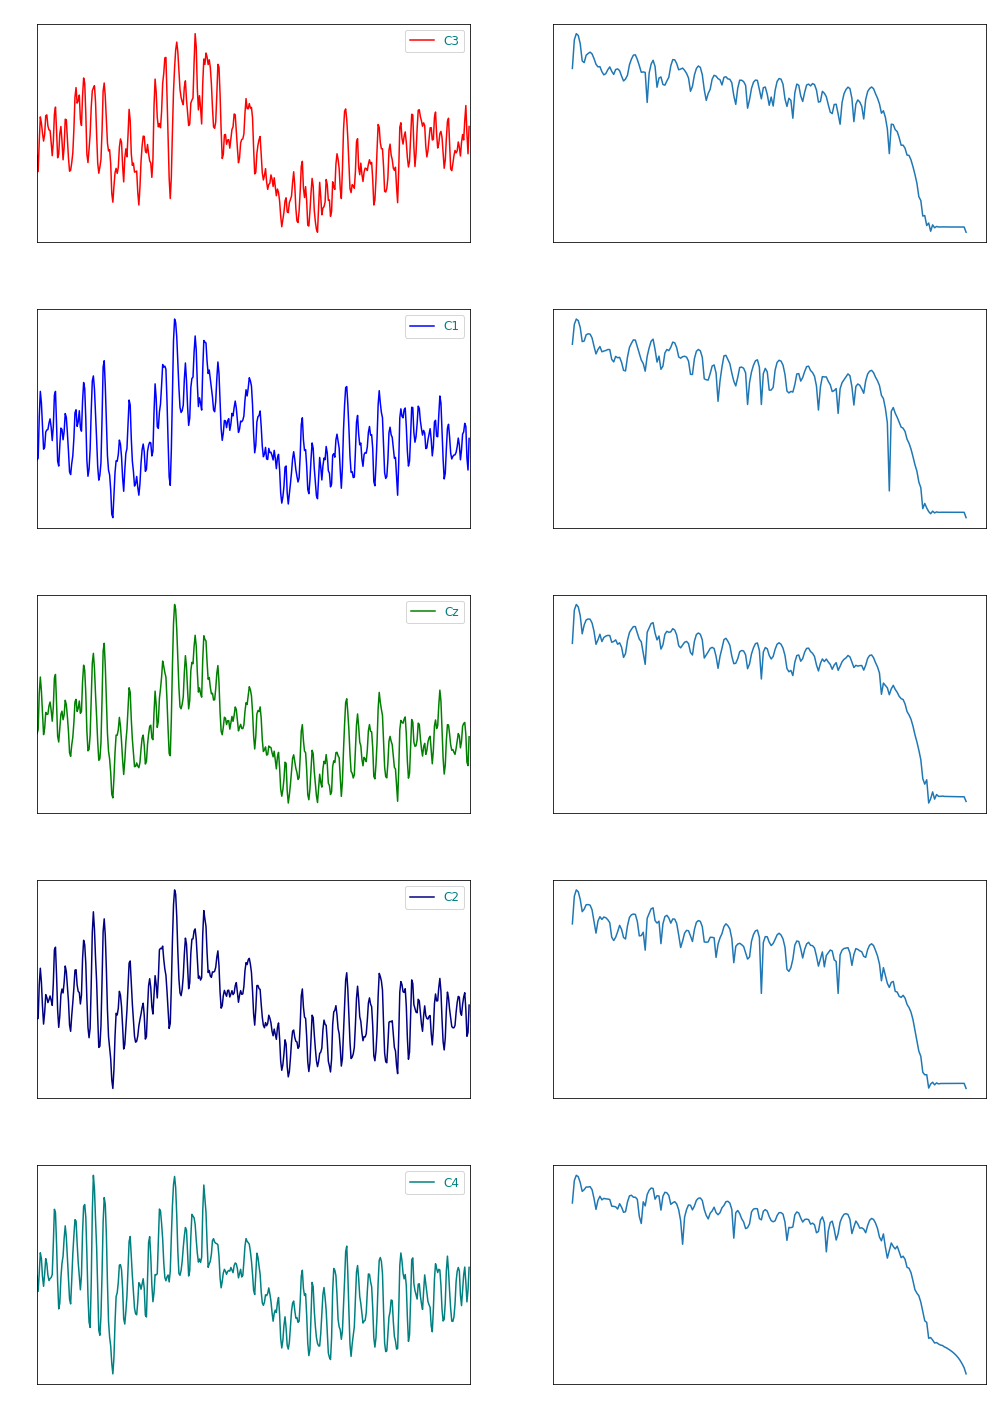

In [21]:
xs = range(WINDOW)
ys = []

for i, _ in enumerate(channelLabel):
     ys += [lowPassFilter(handleData[pos:pos+WINDOW, i], w, level=FILTER_LEVEL)]
ys = np.stack(ys, axis=1)

subplotData(xs, ys, channelNumber, channelLabel, SR)

#### Wavelet Packet Decomposition

In [22]:
import pywt
mode = pywt.Modes.smooth
wav = pywt.Wavelet('db4')

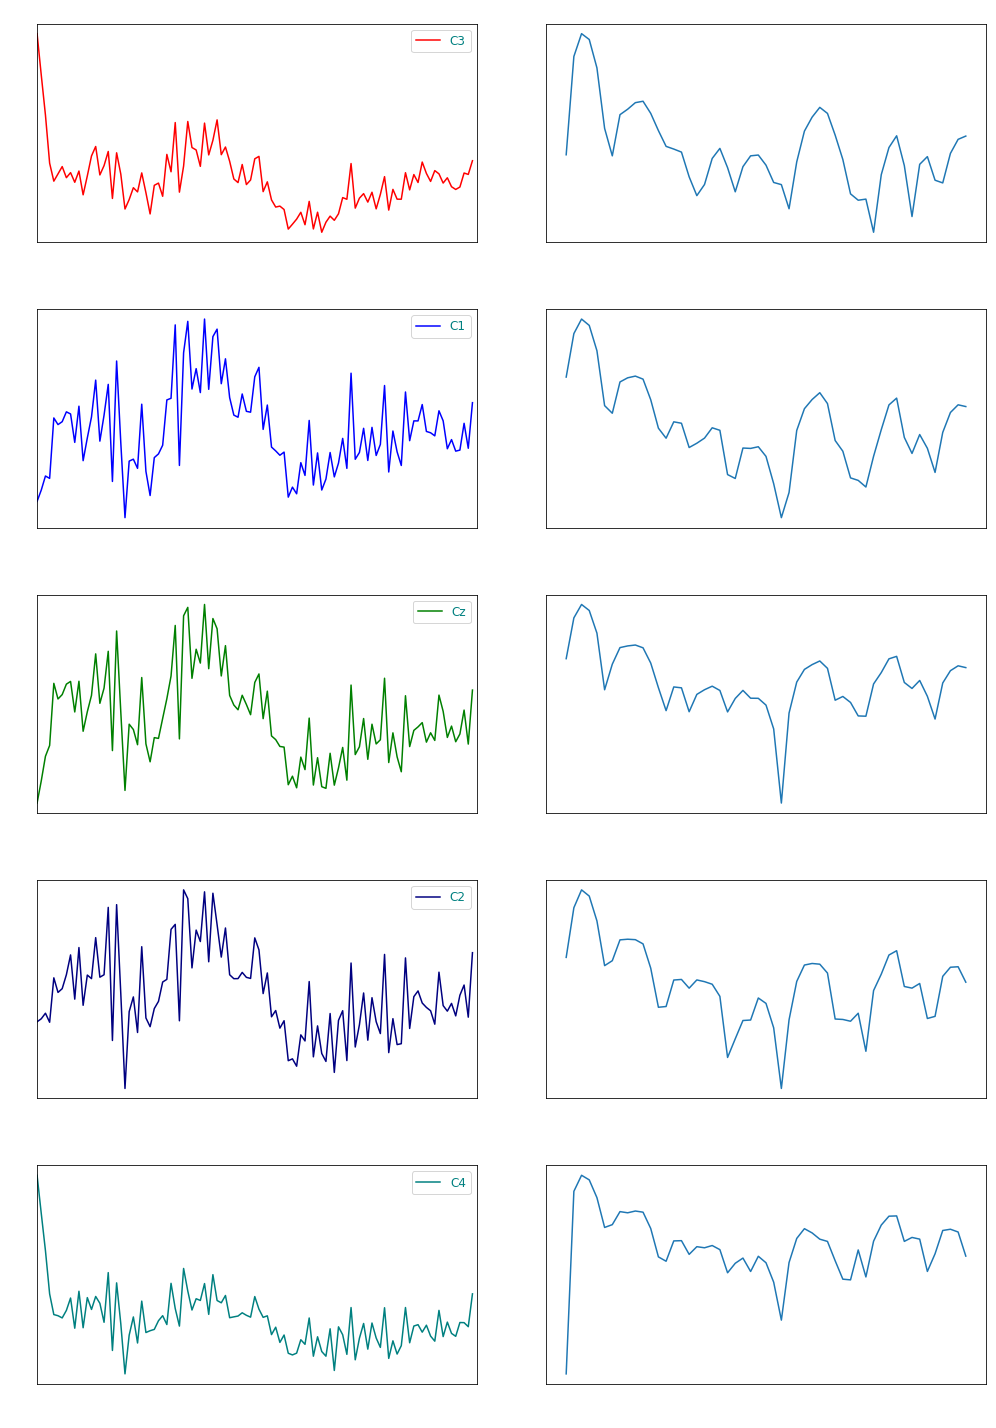

In [23]:
ys = []
for i, _ in enumerate(channelLabel):
    wp = pywt.WaveletPacket(handleData[pos:pos+WINDOW, i], wav, mode)
    ys += [wp['aa'].data]
    
ys = np.stack(ys, axis=1)
xs = range(len(ys))
subplotData(xs, ys, channelNumber, channelLabel, SR)

## Tensorflow

In [1]:
import tensorflow as tf

/home/chrislu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Preprocessing

In [2]:
# Input
import os
import re
import pywt
from scipy.io import loadmat
from scipy import signal
import numpy as np

CURR_DIR = os.getcwd()
PATH = os.path.join('./', 'EEG_MI_BCIIV', 'BCICIV_1')
pattern = re.compile('BCICIV_calib')

calibraPath = []
for root, dirs, files in os.walk(PATH):
    for filename in files:
        if pattern.match(filename):
            calibraPath += [os.path.join(PATH, filename)]
            
mode = pywt.Modes.smooth
wav = pywt.Wavelet('db4')
MI_CHANNEL = ["C1", "C2", "Cz", "C3", "C4"]
fs = 100
WINDOW = 400

In [3]:
x_train = []
y_label = []
cue = []
for path in calibraPath:            
    file = loadmat(path)
    originData = file['cnt']*0.1 # uv
    movement = file['nfo'][0][0][1][0][0:2]
    channel = [(i, item[0]) for i, item \
                in enumerate(file['nfo'][0][0][2][0]) 
                  if MI_CHANNEL in item]
    mark = [*zip(file['mrk'][0][0][0][0], file['mrk'][0][0][1][0])]
    cue += [movement]
    y_label += [x[1] for x in mark]
    channelNumber = [x for x,_ in channel]
    channelLabel = [x for _,x in channel]
    
    x_epoch = []
    for epoch in range(len(mark)):
        pos = mark[epoch][0]
        
        x_col = []
        for i in channelNumber:
            wp = pywt.WaveletPacket(originData[pos:pos+WINDOW, i], wav, mode)
            ys = wp['aa'].data
            f, Pxx_spec = signal.periodogram(ys, fs, 'flattop', scaling='density')
            x_col += [Pxx_spec[:52]]
            
        x_epoch += [np.stack(x_col, axis=0).T]
    x_train += x_epoch

In [4]:
x_train = np.asarray(x_train)
y_label = np.asarray(y_label).astype(np.str)
cue = np.asarray(cue)

for index, val in enumerate(y_label):
    cue_id = index // 200
    if val == '1':
        y_label[index] = cue[cue_id][0][0]
    elif val == '-1':
        y_label[index] = cue[cue_id][1][0]

print(f'input shape = {x_train.shape}')
print(f'label shape = {y_label.shape}')

input shape = (1400, 52, 5)
label shape = (1400,)


### Call Tensorflow 

In [5]:
NCLASSES=3

In [6]:
graph = tf.Graph()
 
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, x_train.shape[-2], x_train.shape[-1]],
        name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, NCLASSES], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [7]:
with graph.as_default():
    # (batch, 52, 5) -> (batch, 26, 10)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=10, kernel_size=2, strides=1,
        padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 26, 10) -> (batch, 13, 20)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=20, kernel_size=2, strides=1,
    padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

In [8]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_2, (-1, 13*20))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, NCLASSES)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
        labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# Normalize
X_tr, X_vld, lab_tr, lab_vld = train_test_split(x_train, y_label, 
                                                stratify = y_label, random_state = 123)

def encoder(data):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    data = label_encoder.fit_transform(data)
    data = data.reshape(len(data), 1)
    data = onehot_encoder.fit_transform(data)
    return data


y_tr = encoder(lab_tr)
y_vld = encoder(lab_vld)

print(f'training data : data shape = {X_tr.shape}')
print(f'validation data : data shape = {X_vld.shape}')

training data : data shape = (1050, 52, 5)
validation data : data shape = (350, 52, 5)


/home/chrislu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/chrislu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto

#### HyperParamter

In [11]:
total_size = X_tr.shape[0]

batch_size = 50                               # 50 batch -> input
learning_rate = 0.001
training_epochs = 10                          # repeat 10 times
tr_total_batches = X_tr.shape[0] // batch_size
vl_total_batches = X_vld.shape[0] // batch_size

In [12]:
from time import time

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    startTime = time()
    
    # Loop over epochs
    for epoch in range(training_epochs): # epochs 
        
        for index in range(tr_total_batches):
            
            offset = (index * batch_size) % (X_tr.shape[0] - batch_size)
            batch_x = X_tr[offset:(offset+batch_size), :, :]
            batch_y = y_tr[offset:(offset+batch_size)]
            # Feed dictionary
            feed = {inputs_ : batch_x, labels_ : batch_y, 
                    keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(epoch, training_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            if (iteration%tr_total_batches == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for index in range(vl_total_batches):
                    batch_x = X_vld[offset:(offset+batch_size), :, :]
                    batch_y = y_vld[offset:(offset+batch_size)]
                    # Feed
                    feed = {inputs_ : batch_x, labels_ : batch_y, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(epoch, training_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
                
            # Iterate 
            iteration += 1
            
    duration = time() - startTime
    print("training time : ", duration)
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/10 Iteration: 5 Train loss: 314.268768 Train acc: 0.340000
Epoch: 0/10 Iteration: 10 Train loss: 68.217842 Train acc: 0.260000
Epoch: 0/10 Iteration: 15 Train loss: 32.874462 Train acc: 0.280000
Epoch: 0/10 Iteration: 20 Train loss: 26.072582 Train acc: 0.380000
Epoch: 0/10 Iteration: 21 Validation loss: 82.559349 Validation acc: 0.480000
Epoch: 1/10 Iteration: 25 Train loss: 29.157059 Train acc: 0.460000
Epoch: 1/10 Iteration: 30 Train loss: 70.853043 Train acc: 0.440000
Epoch: 1/10 Iteration: 35 Train loss: 44.632900 Train acc: 0.420000
Epoch: 1/10 Iteration: 40 Train loss: 46.623409 Train acc: 0.500000
Epoch: 1/10 Iteration: 42 Validation loss: 49.571770 Validation acc: 0.300000
Epoch: 2/10 Iteration: 45 Train loss: 42.465538 Train acc: 0.360000
Epoch: 2/10 Iteration: 50 Train loss: 91.679199 Train acc: 0.440000
Epoch: 2/10 Iteration: 55 Train loss: 39.664398 Train acc: 0.380000
Epoch: 2/10 Iteration: 60 Train loss: 19.030422 Train acc: 0.340000
Epoch: 2/10 Iteration: 63 Va